This notebook presents all the analysis reported in Study 3 of the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Misc
import warnings

warnings.filterwarnings("ignore")
from IPython.display import Markdown


# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

# Statistics
import statsmodels.formula.api as smf
import scipy.stats as stats

# Interface with R
import rpy2

%load_ext rpy2.ipython

%R library(sjstats); # For effect sizes of ANOVAs

STUDY_NAME = "Study 3"

## Functions

In [2]:
def planned_contrasts(contrasts, names, model, use_t=False, alpha=0.05):
    """
    Convenience functions for planned contrasts from a model.
    """
    betas = model.params.values
    vcv = model.cov_params().values
    b = []
    se = []
    for c in contrasts:
        b.append(betas @ c)
        se.append(c @ vcv @ c)
    b = np.array(b)
    se = np.sqrt(se)
    z = b / se
    if use_t:
        df_resid = model.df_resid
        pvals = stats.t(df_resid).sf(np.abs(z)) * 2
        ci_factor = stats.t(df_resid).isf(alpha / 2)
        name_coeff = "t-stats"
    else:
        pvals = stats.norm.sf(np.abs(z)) * 2
        ci_factor = stats.norm.isf(alpha / 2)
        name_coeff = "z-stats"
    llci, ulci = b - se * ci_factor, b + se * ci_factor
    bstd = b / model.model.endog.std(ddof=1)
    df_contrasts = pd.DataFrame(
        {
            "Contrast": names,
            "Beta": b,
            "SE": se,
            name_coeff: z,
            "p-value": pvals,
            "LLCI": llci,
            "ULCI": ulci,
            "Standardized B": bstd,
        }
    )
    return df_contrasts


def plot_result(data, show=True, save=False, grayscale=False, figname="Sequential Learning"):
    if grayscale:
        pal = sns.color_palette("Greys")[1::2]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette("coolwarm", 3)
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    sns.set_style("white")
    g = sns.catplot(
        x="is_manipulated",
        hue="sd_manipulated",
        hue_order=["Low", "Med", "High"],
        y="value_sd",
        data=data,
        kind="bar",
        aspect=1.5,
        height=6.38 / 1.5,
        order=[True, False],
        sharey=False,
        sharex=False,
        legend_out=False,
        palette=pal,
    )

    g.set_titles("")
    g.set_xlabels("")
    leg = g.ax.legend()

    han = leg.legendHandles
    leg.remove()

    g.ax.legend(
        han,
        ["Low (SD = 1.1)", "Med (SD = 4.5)", "High (SD = 7.5)"],
        title="SD of Manipulated Category",
        loc="upper center",
        bbox_to_anchor=(0.75, 1.03),
        frameon=False,
    )
    g.ax.set_ylim(2, 8)
    g.ax.set_xticklabels(["Manipulated Category", "Common Category (SD = 4.5)"])
    g.ax.set_ylabel("SD of Reported Prices")
    plt.tight_layout()
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()

## Data loading and preparation

In [3]:
df = (
    pd.read_csv(f"../Data/{STUDY_NAME}/LongData.csv")
    .groupby(
        ["turkid", "name_manipulated", "is_manipulated", "sd_manipulated", "is_first"]
    )["value"]
    .agg(
        **{
            "value_sd": np.std,
            "value_range": lambda x: np.max(x) - np.min(x),
            "value_min": np.min,
            "value_max": np.max,
            "value_mean": np.mean,
            "value_var": lambda x: np.std(x) ** 2,
        }
    )
    .reset_index()
)

# Design

## Characteristics and distributions

Replication of study 1b: Each participant sees two distributions, one "manipulated", one "common".
* The "common" distribution always has a "Medium" amount of variance (SD = 4.5, Min = 17, Max = 34)
* The "manipulated" distribution has a different variance, between subjects:
    * "Low" (SD = 1.1, Min = 23, Max = 28)
    * "Medium" (SD = 4.5, Min = 17, Max = 34)
    * "High" (SD = 7.5, Min = 13, Max = 38)

This time however, the prices were presented one category at a time.

## Number of valid participants:

In [4]:
df.turkid.unique().shape[0]

290

# Analysis

## Perceived dispersion

### SD

In [5]:
table = (
    df.groupby(["is_manipulated", "sd_manipulated"])[["value_sd"]]
    .mean()
    .reindex(
        labels=[
            [False, False, False, True, True, True],
            ["Low", "Med", "High", "Low", "Med", "High"],
        ]
    )
)
table.index.names = ["Manipulated?", "SD of Manipulated"]
table.columns = ["SD"]
table.style.format("{:.2f}")

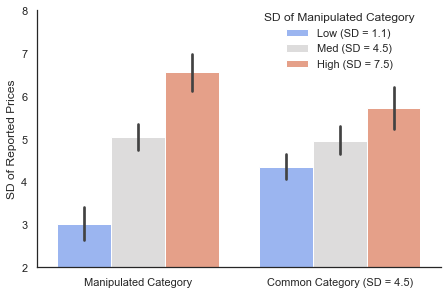

In [6]:
plot_result(df, save=False)

In [7]:
model = smf.mixedlm(
    "value_max ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated, Treatment(0))",
    data=df,
    groups=df.turkid,
).fit()
model.summary(
    yname="SD of Reported Distribution",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
    ],
    xname_re=["Participants Random Effects"],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:              MixedLM Dependent Variable: SD of Reported Distribution
No. Observations:   580     Method:             REML                       
No. Groups:         290     Scale:              19.6269                    
Min. group size:    2       Log-Likelihood:     -1756.8876                 
Max. group size:    2       Converged:          Yes                        
Mean group size:    2.0                                                    
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        33.840    0.513 66.002 0.000 32.835 34.845
Dispersion: Low (vs. Medium)     -0.486    0.733 -0.663 0.507 -1.922  0.950
Dispersion: High (vs. Medium)     1.777    0.737  2.413 0.016  0.333  3.221
Target: Manipulated (vs. Common)  0.420    0.627  0.670 0.503 -0.808  1.648
Dispersion: Low * Target         -3.170    0.895 -3.541 0.000 -4.925 -1.415
Dispersion: High * Target         0.069    0.900  0.077 0.939 -1.695  1.833
Participants Random Effects       6.660    0.439                           
===========================================================================

"""

Standardized betas:

In [8]:
stdbetas = model.params / df.value_sd.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Dispersion: Low (vs. Medium)",
    "Dispersion: High (vs. Medium)",
    "Target: Manipulated (vs. Common)",
    "Dispersion: Low * Target",
    "Dispersion: High * Target",
    "Participants Random Effects",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,15.52
Dispersion: Low (vs. Medium),-0.22
Dispersion: High (vs. Medium),0.81
Target: Manipulated (vs. Common),0.19
Dispersion: Low * Target,-1.45
Dispersion: High * Target,0.03
Participants Random Effects,0.16


In [9]:
Markdown(
    f"""
A mixed linear model with category type (common vs. manipulated) as a within-participant factor 
and the actual price dispersion of the manipulated category (low vs. medium vs. high) as a between-participant 
factor replicated the assimilation effect documented in study 2. 

Indeed, participants created a wider distribution 
for the common category when the manipulated category had a high (vs. medium) amount of dispersion: 
b = {model.params[2]:.3f}, z = {model.tvalues[2]:.3f}, p = {model.pvalues[2]:.3f}, standardized b = {stdbetas[2]:.3f}). 


However, they did not report a lower amount of dispersion for the common category when the manipulated distribution 
had a low (vs. medium) amount of dispersion: 
b = {model.params[1]:.3f}, z = {model.tvalues[1]:.3f}, p = {model.pvalues[1]:.3f}. 
This result also replicates the asymmetry that we had documented in study 2.
"""
)


A mixed linear model with category type (common vs. manipulated) as a within-participant factor 
and the actual price dispersion of the manipulated category (low vs. medium vs. high) as a between-participant 
factor replicated the assimilation effect documented in study 2. 

Indeed, participants created a wider distribution 
for the common category when the manipulated category had a high (vs. medium) amount of dispersion: 
b = 1.777, z = 2.413, p = 0.016, standardized b = 0.815). 


However, they did not report a lower amount of dispersion for the common category when the manipulated distribution 
had a low (vs. medium) amount of dispersion: 
b = -0.486, z = -0.663, p = 0.507. 
This result also replicates the asymmetry that we had documented in study 2.


### Range

In [10]:
model = smf.mixedlm(
    "value_range ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated, Treatment(0))",
    data=df,
    groups=df.turkid,
).fit()
model.summary(
    yname="Range of Reported Distribution",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
    ],
    xname_re=["Participants Random Effects"],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:            MixedLM Dependent Variable: Range of Reported Distribution
No. Observations: 580     Method:             REML                          
No. Groups:       290     Scale:              21.9060                       
Min. group size:  2       Log-Likelihood:     -1840.1068                    
Max. group size:  2       Converged:          Yes                           
Mean group size:  2.0                                                       
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         16.820    0.611 27.536 0.000 15.623 18.017
Dispersion: Low (vs. Medium)      -1.549    0.873 -1.775 0.076 -3.260  0.162
Dispersion: High (vs. Medium)      2.691    0.878  3.066 0.002  0.971  4.411
Target: Manipulated (vs. Common)   0.460    0.662  0.695 0.487 -0.837  1.757
Dispersion: Low * Target          -5.523    0.946 -5.839 0.000 -7.376 -3.669
Dispersion: High * Target          2.285    0.951  2.403 0.016  0.421  4.148
Participants Random Effects       15.406    0.665                           
============================================================================

"""

Standardized betas:

In [11]:
stdbetas = model.params / df.value_range.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Dispersion: Low (vs. Medium)",
    "Dispersion: High (vs. Medium)",
    "Target: Manipulated (vs. Common)",
    "Dispersion: Low * Target",
    "Dispersion: High * Target",
    "Participants Random Effects",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,2.36
Dispersion: Low (vs. Medium),-0.22
Dispersion: High (vs. Medium),0.38
Target: Manipulated (vs. Common),0.06
Dispersion: Low * Target,-0.78
Dispersion: High * Target,0.32
Participants Random Effects,0.10


# Robustness Checks

## Counterbalancing Order - SD

In [12]:
model = smf.mixedlm(
    "value_sd ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated)*C(is_first, Treatment(1))",
    data=df,
    groups=df.turkid,
).fit()
model.summary(
    yname="SD of Reported Distribution",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Counterbalancing Factor (Order)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
        "Dispersion: Low * Order",
        "Dispersion: High * Order",
        "Target * Order",
        "Dispersion: Low * Target * Order",
        "Dispersion: High * Target * Order",
    ],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:             MixedLM  Dependent Variable:  SD of Reported Distribution
No. Observations:  580      Method:              REML                       
No. Groups:        290      Scale:               2.0289                     
Min. group size:   2        Log-Likelihood:      -1162.2711                 
Max. group size:   2        Converged:           Yes                        
Mean group size:   2.0                                                      
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          5.093    0.276 18.436 0.000  4.552  5.634
Dispersion: Low (vs. Medium)      -0.607    0.387 -1.569 0.117 -1.365  0.151
Dispersion: High (vs. Medium)      0.990    0.387  2.560 0.010  0.232  1.748
Target: Manipulated (vs. Common)  -0.277    0.379 -0.730 0.466 -1.021  0.467
Counterbalancing Factor (Order)   -0.277    0.379 -0.730 0.465 -1.021  0.467
Dispersion: Low * Target          -1.156    0.542 -2.133 0.033 -2.217 -0.094
Dispersion: High * Target          0.887    0.545  1.628 0.104 -0.181  1.955
Dispersion: Low * Order           -0.005    0.542 -0.010 0.992 -1.067  1.056
Dispersion: High * Order          -0.500    0.545 -0.917 0.359 -1.568  0.568
Target * Order                     0.741    0.643  1.153 0.249 -0.518  2.001
Dispersion: Low * Target * Order  -0.529    0.918 -0.577 0.564 -2.328  1.269
Dispersion: High * Target * Order -0.222    0.923 -0.240 0.810 -2.030  1.587
Group Var                          1.558    0.214                           
============================================================================

"""

No significant impact.